## Cancer Image Classification

In [ ]:
#!pip install kagglehub

In [1]:
# Import the necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, BatchNormalization, Input
from tensorflow.keras.layers import Activation, AveragePooling2D, Concatenate, Add, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks  import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import os
import warnings
warnings.filterwarnings('ignore')

2025-02-12 10:15:45.507889: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-12 10:15:45.684193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739355345.761309    4452 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739355345.777819    4452 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-12 10:15:45.962036: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### 2. Load the Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohamedhanyyy/chest-ctscan-images")

print("Path to dataset files:", path)

Path to dataset files: /teamspace/studios/this_studio/.cache/kagglehub/datasets/mohamedhanyyy/chest-ctscan-images/versions/1


In [3]:
# dataset_path = "/teamspace/studios/this_studio/.cache/kagglehub/datasets/mohamedhanyyy/chest-ctscan-images/versions/1" 

# # Check downloaded dataset structure
# for root, dirs, files in os.walk(dataset_path):
#     print(f"Directory: {root}")
#     print(f"Subdirectories: {dirs}")
#     print(f"Files: {files}")
#     print("-" * 50)

### 3. Split the dataset into train, test and validation set

In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define dataset paths
dataset_path = "/teamspace/studios/this_studio/.cache/kagglehub/datasets/mohamedhanyyy/chest-ctscan-images/versions/1/Data"

# Load datasets
img_size = (224, 224)
batch_size = 32

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "/train", 
    image_size=img_size, 
    batch_size=batch_size, 
    label_mode='categorical'
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "/valid", 
    image_size=img_size, 
    batch_size=batch_size, 
    label_mode='categorical'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "/test", 
    image_size=img_size, 
    batch_size=batch_size, 
    label_mode='categorical'
)

Found 613 files belonging to 4 classes.
Found 72 files belonging to 4 classes.
Found 315 files belonging to 4 classes.


2025-02-12 10:15:54.070577: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

### 4. Standardize the Image Data

In [9]:
from tensorflow.keras import layers, models

# Normalize images
normalization_layer = layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [10]:
test_dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

### 5. Image Data Augmentation 

In [ ]:
# Image Augmentation

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

Purpose: To increase our data sample and also improve the model robustness

### 6. Defining the Model Architecture

In [7]:
# number of classes
num_classes = 4

# Define CNN model
model = models.Sequential([
    
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),

    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Conv2D(256, (3, 3), activation='relu'),

    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 107, 107, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 51, 51, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 49, 49, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    18,874,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,991,492 (76.26 MB)

 Trainable params: 19,991,492 (76.26 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compile model
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

### 7. Training the Model

In [9]:
# Train model
epochs = 30

history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=epochs
)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.2695 - loss: 1.6962 - val_accuracy: 0.1806 - val_loss: 1.3886
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.3509 - loss: 1.2594 - val_accuracy: 0.2083 - val_loss: 2.4494
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.3226 - loss: 1.6349 - val_accuracy: 0.4861 - val_loss: 1.1376
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.4608 - loss: 1.1952 - val_accuracy: 0.4861 - val_loss: 1.1161
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.4593 - loss: 1.1405 - val_accuracy: 0.4861 - val_loss: 1.0455
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.4369 - loss: 1.2026 - val_accuracy: 0.4861 - val_loss: 1.0508
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.4481 - loss: 1.1388 - val_accuracy: 0.5000 - val_loss: 0.9994
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.4378 - loss: 1.2038 - val_accuracy: 0.4444 - val_loss:

### 8. Evaluating the Model on the Test data

In [10]:
# Evaluate model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

 1/10 ━━━━━━━━━━━━━━━━━━━━ 7s 875ms/step - accuracy: 0.4375 - loss: 1.2157

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 610ms/step - accuracy: 0.4492 - loss: 1.2520
Test Accuracy: 0.4571


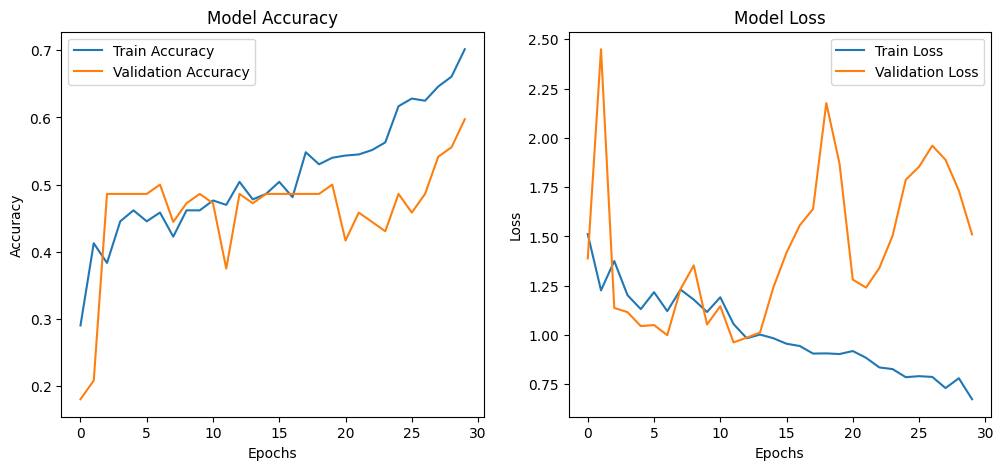

In [11]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

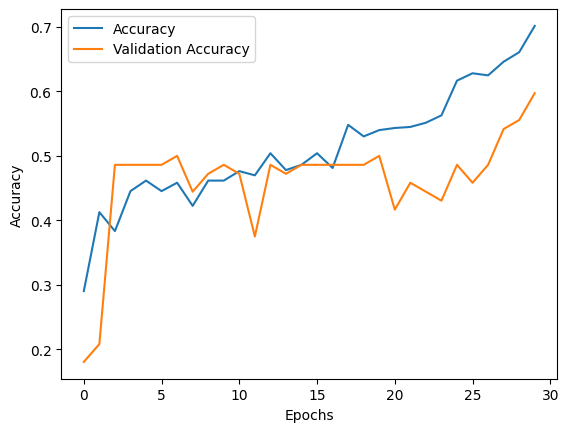

In [12]:
import matplotlib.pyplot as plt


# Plot training history
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
!pip install seaborn

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")

# Predicting on test data
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_dataset.classes
class_labels = list(test_dataset.class_indices.keys())

# Get the accuracy on test data
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot some test images with their predictions
plt.figure(figsize=(12, 12))
for i in range(6):
    plt.subplot(3, 2, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Display image
    img = test_dataset[0][0][i]
    plt.imshow(img)
    
    # Actual label
    actual_label = class_labels[true_classes[i]]

    # Predicted label
    predicted_label = class_labels[predicted_classes[i]]
    
    # Title with actual and predicted labels
    title = f"A: {actual_label}\nP: {predicted_label}\nTest Accuracy: {test_accuracy * 100:.2f}%"
    
    # Check if prediction is correct
    correct = predicted_label == actual_label
    color = "green" if correct else "red"
    
    plt.title(title, color=color)

plt.tight_layout()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 624ms/step


AttributeError: '_MapDataset' object has no attribute 'classes'